This notebook is to do Gaussian fit for each detected HI line, calculate NHI for Component v-220 and v-150 using the pointing toward PHL2525, and plot all the GBT spectra together. 03/28/2019, YZ. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
from astropy.table import Table 
import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'

from astroquery.simbad import Simbad
gal_simbad = Simbad.query_object('DDO221') # WLM = DDO221
coord = SkyCoord(ra=gal_simbad['RA'], dec=gal_simbad['DEC'], unit=(u.hourangle, u.degree))
wlm_l = coord.galactic.l.degree
wlm_b = coord.galactic.b.degree
wlm_ra = coord.icrs.ra.degree
wlm_dec = coord.icrs.dec.degree
print('l = %.4f deg, b = %.4f deg'%(wlm_l, wlm_b))
print('ra = %.4f deg, dec = %.4f deg'%(wlm_ra, wlm_dec))

l = 75.8532 deg, b = -73.6258 deg
ra = 0.4912 deg, dec = -15.4639 deg


In [2]:
qso_simbad = Simbad.query_object('PHL2525')
coord = SkyCoord(ra=qso_simbad['RA'], dec=qso_simbad['DEC'], unit=(u.hourangle, u.degree))
qso_ra = coord.icrs.ra.deg
qso_dec = coord.icrs.dec.deg
print(qso_ra, qso_dec)

[0.10173042] [-12.76327889]


### The GBT spectra 

In [3]:
files = ['data/GBT/GBT_PHL2525_1.txt', 'data/GBT/GBT_PHL2525_2.txt', 'data/GBT/GBT_PHL2525_3.txt', 
         'data/GBT/GBT_PHL2525_4.txt', 'data/GBT/GBT_PHL2525_5.txt', 'data/GBT/GBT_PHL2525_6.txt', 
         'data/GBT/GBT_PHL2525_7.txt', 'data/GBT/GBT_PHL2525_8.txt', 'data/GBT/GBT_PHL2525_9.txt',
         'data/GBT/GBT_PHL2525_10.txt', 'data/GBT/GBT_PHL2525_11.txt', 'data/GBT/GBT_PHL2525_12.txt',
         'data/GBT/GBT_PHL2525_13.txt']

In [8]:
# get coordinates and spectrum from each file  
all_ra = np.zeros(len(files))
all_dec = np.zeros(len(files))
all_vlsr = []
all_flux = []
for i, ifile in enumerate(files):
    # coordinates 
    f = open(ifile)
    for line in f:
        if line[0] == 'c': break
    f.close()

    aline = line.replace('\n', '')
    glon = np.float(aline.split(' ')[-2])
    glat = np.float(aline.split(' ')[-1])

    coord = SkyCoord(glon, glat, frame='galactic', unit=(u.deg, u.deg))
    all_ra[i] = coord.icrs.ra.deg
    all_dec[i] = coord.icrs.dec.deg
    
    # spectrum 
    tb = Table.read(ifile, format='ascii', data_start=4)
    all_vlsr.append(tb['col1'])
    all_flux.append(tb['col2'])
    print(ifile, all_ra[i], all_dec[i], coord.galactic.l.degree, coord.galactic.b.degree)
    
all_ra[all_ra>10] = all_ra[all_ra>10]-360

data/GBT/GBT_PHL2525_1.txt 0.10142350050251854 -12.763224252792869 80.6827 -71.31694
data/GBT/GBT_PHL2525_2.txt 0.9250469747613227 -12.168981901666807 83.80458 -71.31687
data/GBT/GBT_PHL2525_3.txt 0.5097762188118949 -12.461210263471582 82.24366 -71.31689
data/GBT/GBT_PHL2525_4.txt 359.7002354471592 -13.074776257382412 79.12187 -71.31698
data/GBT/GBT_PHL2525_5.txt 359.30618569079826 -13.39568701784762 77.56058 -71.31686
data/GBT/GBT_PHL2525_6.txt 359.47431524308564 -11.972841921293012 80.68285 -70.31698
data/GBT/GBT_PHL2525_7.txt 359.78738075014564 -12.368198170261328 80.68277 -70.81694
data/GBT/GBT_PHL2525_8.txt 0.4164732035704177 -13.15784668786537 80.68275 -71.81693
data/GBT/GBT_PHL2525_9.txt 0.7323535761827912 -13.552072098702762 80.68236 -72.3168
data/GBT/GBT_PHL2525_10.txt 0.8248137851897216 -12.855782646845205 82.2836 -71.8169
data/GBT/GBT_PHL2525_11.txt 359.38524829567575 -12.678590458675233 79.15974 -70.81588
data/GBT/GBT_PHL2525_12.txt 0.015050135410277164 -13.470176842198638 

Fit each GBT detection separately 

In [7]:
def gaussian(v, a, v0, sigma):
    return a*np.exp(-(v-v0)**2/sigma**2)
from scipy.optimize import curve_fit

In [8]:
all_vmin, all_vmax = -360, -90

pointing 4
v     : -204.70+/-0.43 km/s
sig_v : 15.46+/-0.60 km/s
logNHI: 19.02+/-0.01


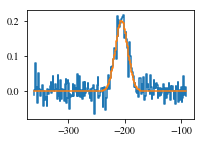

In [9]:
i = 3 # pointing 4 
ind = np.all([all_vlsr[i]>all_vmin, all_vlsr[i]<all_vmax], axis=0)
spec_x, spec_y = all_vlsr[i][ind], all_flux[i][ind]
del_v = np.mean(spec_x[1:]-spec_x[:-1])
    
pp_3, pcov_3 = curve_fit(gaussian, spec_x, spec_y, p0=[0.2, -200, 15])
perr_3 = np.sqrt(np.diag(pcov_3))
yfit_3 = gaussian(spec_x, *pp_3)


fwhm = pp_3[2]*2.355
ind_v = np.all([spec_x>all_vmin, spec_x<all_vmin+fwhm*2], axis=0)
sig_nhi_3 = np.sum(spec_y[ind_v]*1.823e18*del_v)
nhi_3 = np.sum(spec_y*1.823e18*del_v)

print('pointing %s'%(i+1))
print('v     : %.2f+/-%.2f km/s'%(pp_3[1], perr_3[1]))
print('sig_v : %.2f+/-%.2f km/s'%(pp_3[2], perr_3[2]))
print('logNHI: %.2f+/-%.2f'%(np.log10(nhi_3), sig_nhi_3/nhi_3/np.log(10)))
      
plt.figure(figsize=(3,2))
plt.step(spec_x, spec_y)
plt.step(spec_x, yfit_3)

pointing 5
v     : -225.49+/-0.88 km/s
sig_v : 17.34+/-1.39 km/s
v     : -189.35+/-3.86 km/s
sig_v : 29.19+/-4.69 km/s
logNHI: 18.83+/--0.00


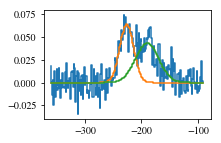

In [10]:
i = 4 # pointing 5 
ind = np.all([all_vlsr[i]>all_vmin, all_vlsr[i]<all_vmax], axis=0)
spec_x, spec_y = all_vlsr[i][ind], all_flux[i][ind]
del_v = np.mean(spec_x[1:]-spec_x[:-1])
    
inda = spec_x<-210
pp_4a, pcov_4a = curve_fit(gaussian, spec_x[inda], spec_y[inda], p0=[0.1, -230, 15])
perr_4a = np.sqrt(np.diag(pcov_4a))
yfit_4a = gaussian(spec_x, *pp_4a)

indb = spec_x>-200
pp_4b, pcov_4b = curve_fit(gaussian, spec_x[indb], spec_y[indb], p0=[0.08, -190, 10])
perr_4b = np.sqrt(np.diag(pcov_4b))
yfit_4b = gaussian(spec_x, *pp_4b)

fwhm = 40
ind_v = np.all([spec_x>all_vmin, spec_x<all_vmin+fwhm*2], axis=0)
sig_nhi_4 = np.sum(spec_y[ind_v]*1.823e18*del_v)
nhi_4 = np.sum(spec_y*1.823e18*del_v)

print('pointing %s'%(i+1))
print('v     : %.2f+/-%.2f km/s'%(pp_4a[1], perr_4a[1]))
print('sig_v : %.2f+/-%.2f km/s'%(pp_4a[2], perr_4a[2]))
print('v     : %.2f+/-%.2f km/s'%(pp_4b[1], perr_4b[1]))
print('sig_v : %.2f+/-%.2f km/s'%(pp_4b[2], perr_4b[2]))
print('logNHI: %.2f+/-%.2f'%(np.log10(nhi_4), sig_nhi_4/nhi_4/np.log(10)))
      
plt.figure(figsize=(3,2))
plt.step(spec_x, spec_y)
plt.step(spec_x, yfit_4a)
plt.step(spec_x, yfit_4b)

pointing 6
v     : -189.79+/-0.38 km/s
sig_v : 15.53+/-0.54 km/s
logNHI: 18.94+/--0.00


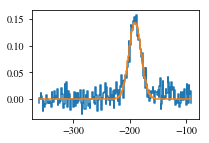

In [11]:
i = 5 # pointing 6 
ind = np.all([all_vlsr[i]>all_vmin, all_vlsr[i]<all_vmax], axis=0)
spec_x, spec_y = all_vlsr[i][ind], all_flux[i][ind]
del_v = np.mean(spec_x[1:]-spec_x[:-1])
    
pp_5, pcov_5 = curve_fit(gaussian, spec_x, spec_y, p0=[0.16, -190, 15])
perr_5 = np.sqrt(np.diag(pcov_5))
yfit_5 = gaussian(spec_x, *pp_5)


fwhm = pp_5[2]*2.355
ind_v = np.all([spec_x>all_vmin, spec_x<all_vmin+fwhm*2], axis=0)
sig_nhi_5 = np.sum(spec_y[ind_v]*1.823e18*del_v)
nhi_5 = np.sum(spec_y*1.823e18*del_v)

print('pointing %s'%(i+1))
print('v     : %.2f+/-%.2f km/s'%(pp_5[1], perr_5[1]))
print('sig_v : %.2f+/-%.2f km/s'%(pp_5[2], perr_5[2]))
print('logNHI: %.2f+/-%.2f'%(np.log10(nhi_5), sig_nhi_5/nhi_5/np.log(10)))
      
plt.figure(figsize=(3,2))
plt.step(spec_x, spec_y)
plt.step(spec_x, yfit_5)

pointing 8
v     : -250.97+/-0.23 km/s
sig_v : 12.70+/-0.33 km/s
logNHI: 19.14+/-0.01


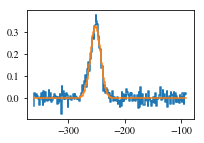

In [12]:
i = 7 # pointing 8
ind = np.all([all_vlsr[i]>all_vmin, all_vlsr[i]<all_vmax], axis=0)
spec_x, spec_y = all_vlsr[i][ind], all_flux[i][ind]
del_v = np.mean(spec_x[1:]-spec_x[:-1])
    
pp_7, pcov_7 = curve_fit(gaussian, spec_x, spec_y, p0=[0.36, -250, 15])
perr_7 = np.sqrt(np.diag(pcov_7))
yfit_7 = gaussian(spec_x, *pp_7)


fwhm = pp_7[2]*2.355
ind_v = np.all([spec_x>all_vmin, spec_x<all_vmin+fwhm*2], axis=0)
sig_nhi_7 = np.sum(spec_y[ind_v]*1.823e18*del_v)
nhi_7 = np.sum(spec_y*1.823e18*del_v)

print('pointing %s'%(i+1))
print('v     : %.2f+/-%.2f km/s'%(pp_7[1], perr_7[1]))
print('sig_v : %.2f+/-%.2f km/s'%(pp_7[2], perr_7[2]))
print('logNHI: %.2f+/-%.2f'%(np.log10(nhi_7), sig_nhi_7/nhi_7/np.log(10)))
      
plt.figure(figsize=(3,2))
plt.step(spec_x, spec_y)
plt.step(spec_x, yfit_7)

pointing 10
v     : -258.32+/-0.42 km/s
sig_v : 16.31+/-0.59 km/s
logNHI: 18.96+/--0.00


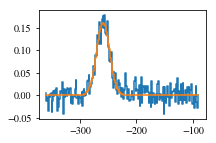

In [13]:
i = 9 # pointing 10
ind = np.all([all_vlsr[i]>all_vmin, all_vlsr[i]<all_vmax], axis=0)
spec_x, spec_y = all_vlsr[i][ind], all_flux[i][ind]
del_v = np.mean(spec_x[1:]-spec_x[:-1])
    
pp_9, pcov_9 = curve_fit(gaussian, spec_x, spec_y, p0=[0.28, -260, 15])
perr_9 = np.sqrt(np.diag(pcov_9))
yfit_9 = gaussian(spec_x, *pp_9)


fwhm = pp_9[2]*2.355
ind_v = np.all([spec_x>all_vmin, spec_x<all_vmin+fwhm*2], axis=0)
sig_nhi_9 = np.sum(spec_y[ind_v]*1.823e18*del_v)
nhi_9 = np.sum(spec_y*1.823e18*del_v)

print('pointing %s'%(i+1))
print('v     : %.2f+/-%.2f km/s'%(pp_9[1], perr_9[1]))
print('sig_v : %.2f+/-%.2f km/s'%(pp_9[2], perr_9[2]))
print('logNHI: %.2f+/-%.2f'%(np.log10(nhi_9), sig_nhi_9/nhi_9/np.log(10)))
      
plt.figure(figsize=(3,2))
plt.step(spec_x, spec_y)
plt.step(spec_x, yfit_9)

pointing 11
v     : -203.25+/-0.51 km/s
sig_v : 20.52+/-0.72 km/s
logNHI: 19.02+/-0.01


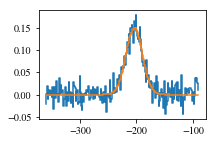

In [14]:
i = 10 # pointing 11
ind = np.all([all_vlsr[i]>all_vmin, all_vlsr[i]<all_vmax], axis=0)
spec_x, spec_y = all_vlsr[i][ind], all_flux[i][ind]
del_v = np.mean(spec_x[1:]-spec_x[:-1])
    
pp_10, pcov_10 = curve_fit(gaussian, spec_x, spec_y, p0=[0.26, -200, 15])
perr_10 = np.sqrt(np.diag(pcov_10))
yfit_10 = gaussian(spec_x, *pp_10)


fwhm = 50
ind_v = np.all([spec_x>all_vmin, spec_x<all_vmin+fwhm*2], axis=0)
sig_nhi_10 = np.sum(spec_y[ind_v]*1.823e18*del_v)
nhi_10 = np.sum(spec_y*1.823e18*del_v)

print('pointing %s'%(i+1))
print('v     : %.2f+/-%.2f km/s'%(pp_10[1], perr_10[1]))
print('sig_v : %.2f+/-%.2f km/s'%(pp_10[2], perr_10[2]))
print('logNHI: %.2f+/-%.2f'%(np.log10(nhi_10), sig_nhi_10/nhi_10/np.log(10)))
      
plt.figure(figsize=(3,2))
plt.step(spec_x, spec_y)
plt.step(spec_x, yfit_10)

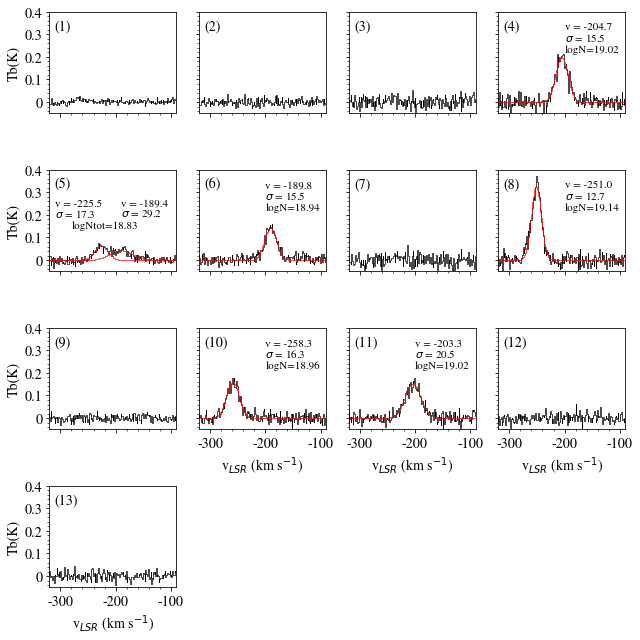

In [15]:
fig = plt.figure(figsize=(9, 9))
# fig, axes = plt.subplots(2, 7, sharex='col', sharey='row', figsize=(10, 4.5))

for i in range(len(all_ra)):
    ax = fig.add_subplot(4, 4, i+1)
    
    ind = np.all([all_vlsr[i]<all_vmax, all_vlsr[i]>all_vmin], axis=0)
    spec_x, spec_y = all_vlsr[i][ind], all_flux[i][ind]
    
    ax.step(spec_x, spec_y, color='k', lw=0.7)
    ax.text(-310, 0.32, '(%s)'%(files[i].replace('.', '_').split('_')[-2]), fontsize=14)

    # Gaussian fit:
    fs = 11
    if i == 3: # one Gaussian 
        ax.step(spec_x, yfit_3, color='r', lw=0.7)
        ax.text(-200, 0.32, 'v = %.1f'%(pp_3[1]), fontsize=fs)
        ax.text(-200, 0.27, r'$\sigma$ = %.1f'%(pp_3[2]), fontsize=fs)
        ax.text(-200, 0.22, 'logN=%.2f'%(np.log10(nhi_3)), fontsize=fs)
        
    if i == 4: # one Gaussian 
        ax.step(spec_x, yfit_4a, color='r', lw=0.7)
        ax.text(-310, 0.24, 'v = %.1f'%(pp_4a[1]), fontsize=fs)
        ax.text(-310, 0.19, r'$\sigma$ = %.1f'%(pp_4a[2]), fontsize=fs)
        
        ax.step(spec_x, yfit_4b, color='r', lw=0.7)
        ax.text(-190, 0.24, 'v = %.1f'%(pp_4b[1]), fontsize=fs)
        ax.text(-190, 0.19, r'$\sigma$ = %.1f'%(pp_4b[2]), fontsize=fs)
        ax.text(-280, 0.14, 'logNtot=%.2f'%(np.log10(nhi_4)), fontsize=fs)
        
    if i == 5: # one Gaussian 
        ax.step(spec_x, yfit_5, color='r', lw=0.7)
        ax.text(-200, 0.32, 'v = %.1f'%(pp_5[1]), fontsize=fs)
        ax.text(-200, 0.27, r'$\sigma$ = %.1f'%(pp_5[2]), fontsize=fs)
        ax.text(-200, 0.22, 'logN=%.2f'%(np.log10(nhi_5)), fontsize=fs)
        
    if i == 7: # one Gaussian 
        ax.step(spec_x, yfit_7, color='r', lw=0.7)
        ax.text(-200, 0.32, 'v = %.1f'%(pp_7[1]), fontsize=fs)
        ax.text(-200, 0.27, r'$\sigma$ = %.1f'%(pp_7[2]), fontsize=fs)
        ax.text(-200, 0.22, 'logN=%.2f'%(np.log10(nhi_7)), fontsize=fs)
        
    if i == 9: # one Gaussian 
        ax.step(spec_x, yfit_9, color='r', lw=0.7)
        ax.text(-200, 0.32, 'v = %.1f'%(pp_9[1]), fontsize=fs)
        ax.text(-200, 0.27, r'$\sigma$ = %.1f'%(pp_9[2]), fontsize=fs)
        ax.text(-200, 0.22, 'logN=%.2f'%(np.log10(nhi_9)), fontsize=fs)
        
    if i == 10: # one Gaussian 
        ax.step(spec_x, yfit_10, color='r', lw=0.7)
        ax.text(-200, 0.32, 'v = %.1f'%(pp_10[1]), fontsize=fs)
        ax.text(-200, 0.27, r'$\sigma$ = %.1f'%(pp_10[2]), fontsize=fs)
        ax.text(-200, 0.22, 'logN=%.2f'%(np.log10(nhi_10)), fontsize=fs)
        
    # figure layout 
    ax.set_xlim(-320, -90)
    ax.set_ylim(-0.05, 0.4)
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
    ax.set_xticks([-300, -200, -100])
    ax.minorticks_on()
    if i in [0, 4, 8, 12]:
        ax.set_yticklabels(['0', '0.1', '0.2', '0.3', '0.4'], fontsize=14)
        ax.set_ylabel('Tb(K)', fontsize=14)
    else:
        ax.set_yticklabels([])
    
    if i > 8:
        ax.set_xticklabels(['-300', '-200', '-100'], fontsize=14)
        ax.set_xlabel(r'v$_{LSR}$ (km s$^{-1}$)', fontsize=14)
    else:
        ax.set_xticklabels([])
        
fig.tight_layout()
fig.savefig('figs/GBT_spec.pdf')

In [17]:
v_err = [0.42, 1.22, 3.86, 0.45, 0.22, 0.41, 0.55]
sig_err = [0.60, 1.93, 4.7, 0.63, 0.31, 0.58, 0.78]
np.median(v_err), np.mean(v_err), np.median(sig_err), np.mean(sig_err)

(0.45, 1.0185714285714285, 0.63, 1.3614285714285714)

GBT spectra for pointing toward PHL2525 and NHI upper limit (3sigma)

In [18]:
# phl2525
phl2525_tb = Table.read('Data/GBT/GBT_PHL2525_1.txt', format='ascii', data_start=4)
phl2525_vlsr = phl2525_tb['col1']
phl2525_flux = phl2525_tb['col2']

ind1 = np.all([phl2525_vlsr>-150.2-41/2., phl2525_vlsr<-150.2+41/2.], axis=0)
vstep1 = np.mean(phl2525_vlsr[1:]-phl2525_vlsr[:-1])
nhi1 = (1.823e18 * phl2525_flux[ind1] * vstep1).sum()
print(nhi1, nhi1*3, np.log10(nhi1*3))

ind2 = np.all([phl2525_vlsr>-150.2-58/2., phl2525_vlsr<-150.2+58/2.], axis=0)
vstep2 = np.mean(phl2525_vlsr[1:]-phl2525_vlsr[:-1])
nhi2 = (1.823e18 * phl2525_flux[ind2] * vstep2).sum()
print(nhi2, nhi2*3, np.log10(nhi2*3))

3.4539333525456326e+17 1.0361800057636897e+18 18.015435207840817
3.7188838516933696e+17 1.1156651555080109e+18 18.047533869390453


GBT spectra for WLM 

Text(0.5, 1.0, 'WLM/GBT')

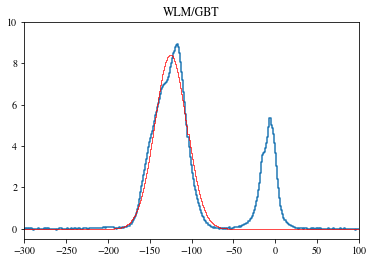

In [20]:
wlm_tb = Table.read('Data/GBT/GBT_WLM.txt', format='ascii', data_start=4)
wlm_vlsr = wlm_tb['col1']
wlm_flux = wlm_tb['col2']

ind = wlm_vlsr < -50
pp = curve_fit(gaussian, wlm_vlsr[ind], wlm_flux[ind], p0=[9, -130, 30])[0]
yfit = gaussian(wlm_vlsr, *pp)

plt.step(wlm_vlsr, wlm_flux)
plt.step(wlm_vlsr, yfit, color='r', lw=0.7)
plt.xlim(-300, 100)
plt.ylim(-0.5, 10)
plt.title('WLM/GBT')